 # MVPA Music vs. Noise LS-A

In [1]:
import numpy as np
import nibabel as nb
import os
from nilearn.input_data import NiftiMasker

In [2]:
# define paths
#root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
root_dir = '/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_01_musicnoise')

# brain masks
#mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c_res-2_dilated.nii')
mask_gm_file    = os.path.join(root_dir, 'derivatives', 'mni_icbm152_gm_tal_nlin_asym_09c.nii')

# Numer of runs per participant
nRunsPerSub = 4

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_musicnoise_confounds_dataset.nii.gz') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_musicnoise_confounds_trial_types.txt') & f.startswith('sub-')]
label_files.sort()

In [4]:
# get number of subjects
# if this is not an integer, something is wrong
n_subjects = len(dataset_files) / nRunsPerSub
print('Number of subjects found: %f' % n_subjects)

Number of subjects found: 17.000000


In [5]:
# concatenate all datasets (estimated duration: 50 seconds)
D = nb.concat_images(dataset_files, axis=3)

/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(



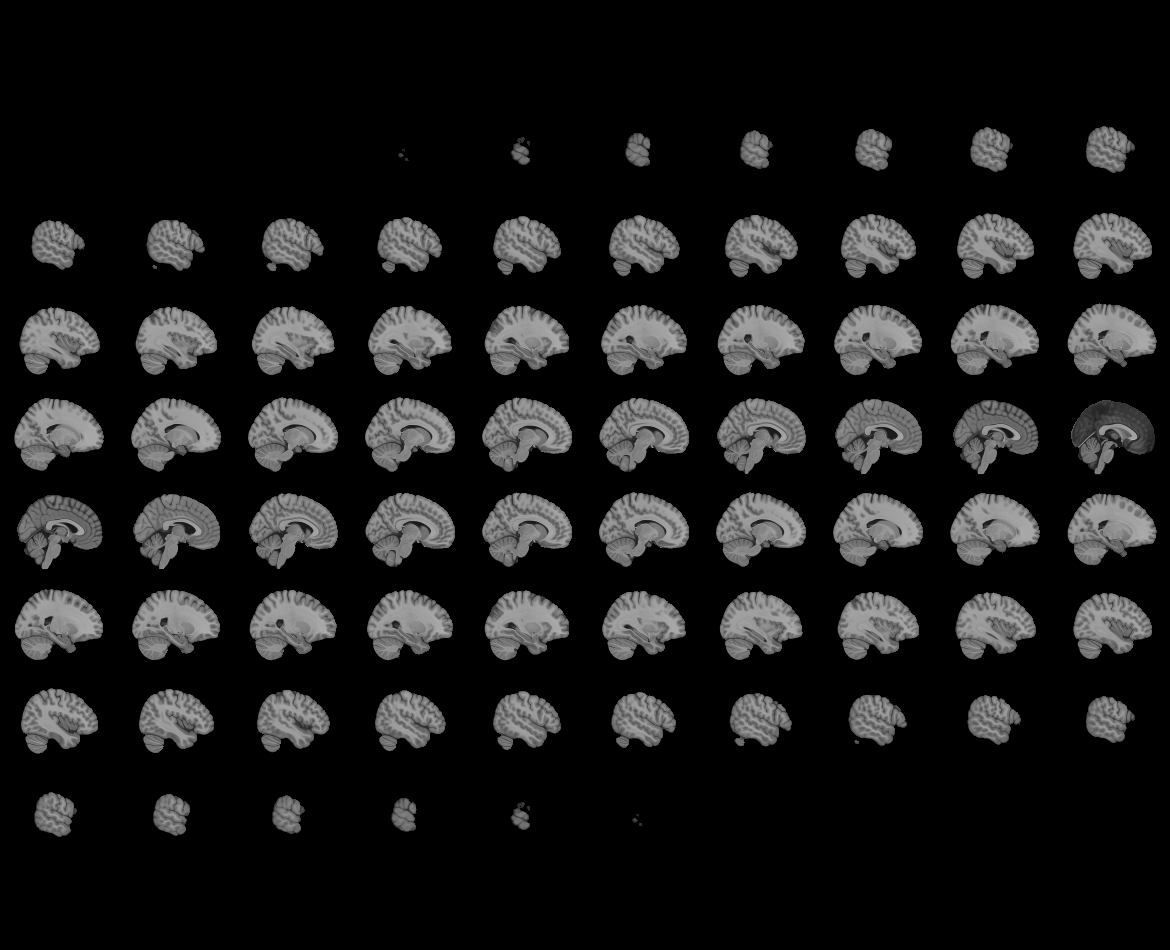
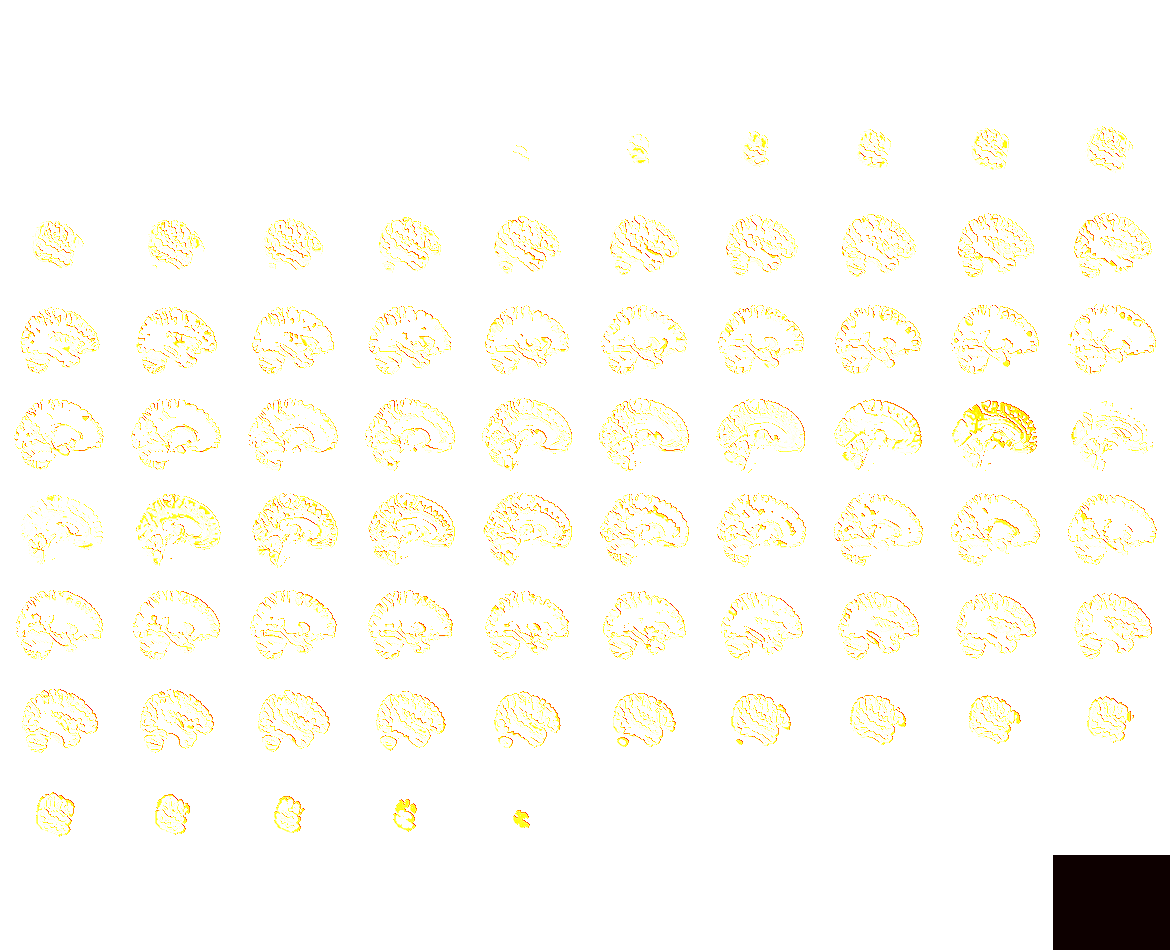

In [6]:
# Create GM mask
from nilearn import plotting
from nilearn.image import math_img, resample_to_img

mask_resample = resample_to_img(mask_gm_file, D, interpolation='nearest')
mask_gm = math_img('img > 0.5', img=mask_resample)

plotting.view_img(mask_gm)

In [7]:
# concatenate all labels into a single string array
labels = np.concatenate([np.loadtxt(l, dtype=str) for l in label_files])

# trim each label to remove the 2 digit number in the end
labels = np.array([l[:-2] for l in labels])

In [8]:
# Load masker
masker = NiftiMasker(mask_img=mask_gm, standardize=False, detrend=False)

# Extract data from mask (estimated duration: 3 minutes)
samples = masker.fit_transform(D)

In [9]:
# generate an array of chunk labels
# 17 subjects, 10 noise and 9 x 2 music for each of the 4 runs
chunks = np.repeat(np.arange(1,n_subjects+1), 10*4 + 9*2*nRunsPerSub)

In [22]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class="ovr", max_iter=2000, class_weight='balanced', dual='auto')

## Manual Leave One Subject Out Cross Validation

In [11]:
#PARALLEL
from sklearn.metrics import balanced_accuracy_score
from joblib import Parallel, delayed
from sklearn.svm import LinearSVC

n_folds = int(n_subjects)
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)

def per_fold(ff,n_folds,chunks,samples,labels,acc_array,acc_bal_array):
    print(f'fold {ff+1}/{n_folds}...')

    clf = LinearSVC(multi_class="ovr", max_iter=5000, class_weight='balanced', dual='auto')

    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask, :]
    y_train = labels[train_mask]
    X_test = samples[test_mask, :]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

Parallel(n_jobs=17)(delayed(per_fold)(ff,n_folds,chunks,samples,labels,acc_array,acc_bal_array) for ff in range(n_folds))

fold 13/17...fold 17/17...

fold 2/17...
fold 10/17...fold 5/17...

fold 15/17...
fold 16/17...
fold 14/17...
fold 8/17...
fold 7/17...
fold 11/17...
fold 6/17...
fold 12/17...
fold 4/17...
fold 3/17...fold 9/17...

fold 1/17...


In [ ]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 0.0% ± 0.0%
Mean balanced accuracy: 0.0% ± 0.0%


fold 0/17...


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fold 1/17...


KeyboardInterrupt: 

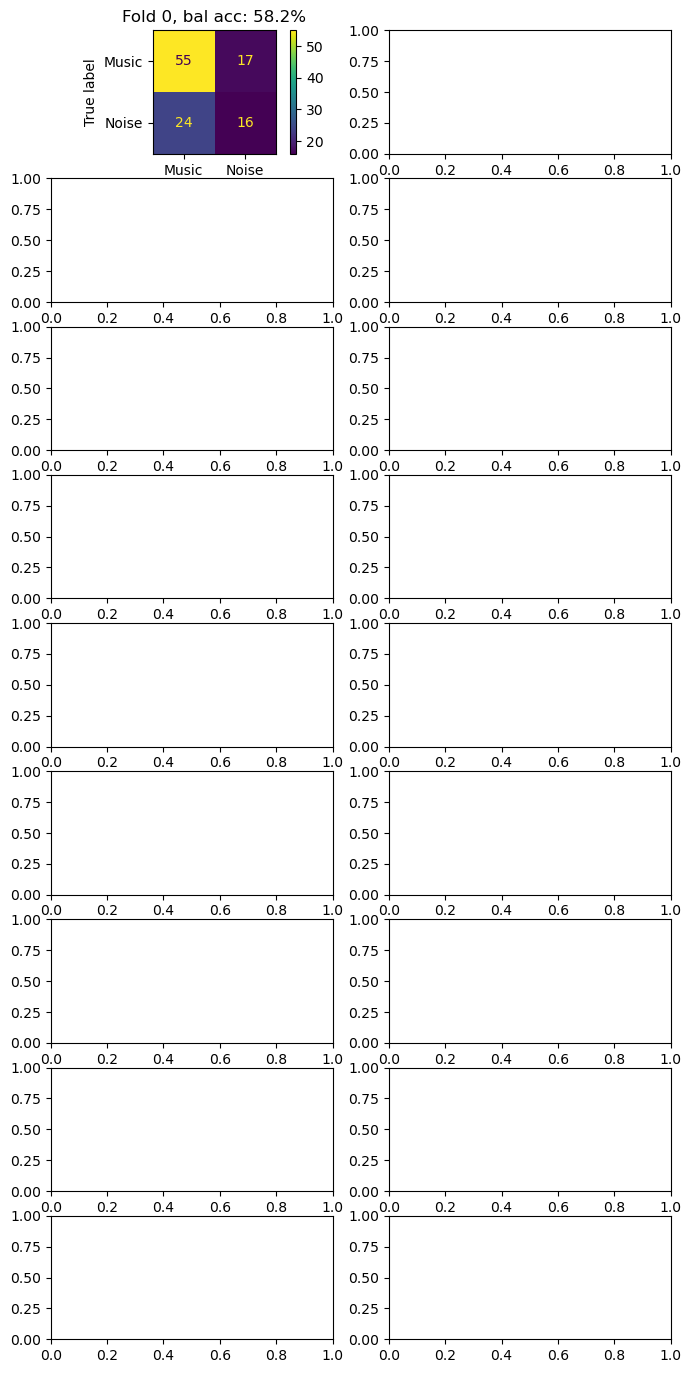

In [23]:
# estimated duration: 10 minutes
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
import math
%matplotlib inline

n_folds = int(n_subjects)
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)
fig, ax = plt.subplots(math.ceil(n_folds/2), 2, figsize=(8, n_folds))

for ff in range(n_folds):
    print(f'fold {ff+1}/{n_folds}...')

    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask, :]
    y_train = labels[train_mask]
    X_test = samples[test_mask, :]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix plots
    #ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[ff // 2, ff % 2])
    #ax[ff // 2, ff % 2].set_title(f"Fold {ff}, bal acc: {acc_bal_array[ff]*100:0.1f}%")

plt.tight_layout()


In [ ]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 86.6% ± 5.3%
Mean balanced accuracy: 83.2% ± 6.3%


## Visualize weights in the brain

In [ ]:
#ToDo

# Nilearn functions

In [ ]:
from nilearn.decoding import Decoder
#from sklearn.model_selection import LeaveOneGroupOut

decoder = Decoder(
    estimator="svc",
    mask=mask_gm_file,
    standardize=False,
    cv=17,
    scoring="accuracy",
    n_jobs=6,
    verbose=1,
)
decoder.fit(D, labels)

print(decoder.cv_params_["Music"])

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.fit] Finished fit
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1904),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    0     4     5     6    74  6102  6104  6382  6387  6388  6393  6394
  6408  6417  6705  6714  6715  6716  6723  6724  6725  6726  6732  6733
  6734  6740  6746  6747  6753  6754  7092  7104  7105  7114  7490  7875
  8360  8892 17553 17580 18184 18207 18208 18231 18864 18879 18880 19291
 19300 19301 19302 19313 19314 19315 19323 19327 19330 19648 19653 19654
 19655 19657 19936 24654 25112 25204 25223 25232 25333 25334 25335 25346
 25347 25449 25450 25451 25452 25453 25456 25516 25517 25518 25519 25533
 25534 25535 25536] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 

KeyboardInterrupt: 

In [ ]:
from nilearn import plotting
plotting.view_img(
    decoder.coef_img_["Music"],
    title="SVM weights",
    dim=-1,
)

In [ ]:
dummy_decoder = Decoder(
    estimator="dummy_classifier",
    mask=mask_filename,
    groups=chunks,
    cv=LeaveOneGroupOut()
    standardize="zscore_sample",
)
dummy_decoder.fit(fmri_niimgs, conditions, groups=run_label)

# Now, we can compare these scores by simply taking a mean over folds
print(dummy_decoder.cv_scores_)